# Rescaling dataset from HSD to force

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

### Load dataset

In [20]:
cols_to_keep = ["position", "hair_stick_distance", "norm1", "norm2", "norm3", "norm4"]

dataset_folder = "./dataset/"
dataset_filename = ""
dataset_filepath = os.path.join(dataset_folder, dataset_filename)
dataset = pd.read_csv(dataset_filepath)

dataset

,position,hair_stick_distance,norm1,norm2,norm3,norm4
0,0.0,0.0,0.784800,0.971310,0.962471,0.982348
1,0.0,0.0,0.782640,0.970345,0.967529,0.980870
2,0.0,0.0,0.785600,0.966759,0.965765,0.981391
3,0.0,0.0,0.782000,0.962759,0.968353,0.981478
4,0.0,0.0,0.784320,0.960897,0.967647,0.980522
...,...,...,...,...,...,...
228829,660.0,0.0,0.891272,0.959452,0.984906,0.852252
228830,660.0,0.0,0.896520,0.955290,0.989712,0.854900
228831,660.0,0.0,0.900548,0.954728,0.986306,0.858109
228832,660.0,0.0,0.890096,0.965345,0.992553,0.872565


### Correct and interpolate HSD values

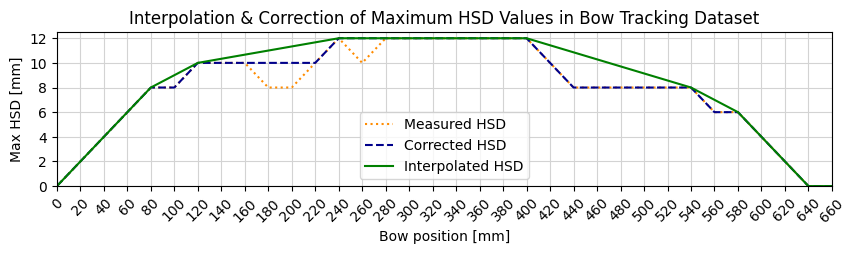

In [21]:
hsd_range = [0, 12]

dataset_size = len(dataset.index)

pos_uniques = dataset["position"].unique()

pos_hsd_maxes = {}

for pos in pos_uniques:
    pos_subset = dataset[dataset["position"] == pos]
    hsd_max = pos_subset["hair_stick_distance"].max()
    pos_hsd_maxes[pos] = hsd_max

pos_hsd_maxes_corrected = pos_hsd_maxes.copy()

# Manually change values at sensor positions
pos_hsd_maxes_corrected[180] = 10
pos_hsd_maxes_corrected[200] = 10
pos_hsd_maxes_corrected[260] = 12

pos_hsd_maxes_interp = pos_hsd_maxes_corrected.copy()

pos_step = 20 # mm

ranges_to_interp = [[80, 120], [120, 240], [400, 540], [540, 580]]

for range in ranges_to_interp:
    interp_hsd_values = np.linspace(
        pos_hsd_maxes[range[0]], 
        pos_hsd_maxes[range[1]], 
        int((range[1]-range[0]) / pos_step),
        endpoint=False
    )

    for i, new_hsd_max in enumerate(interp_hsd_values):
        interp_pos = range[0] + (i * 20)
        pos_hsd_maxes_interp[interp_pos] = new_hsd_max

plt.figure(figsize=(10,2))
plt.plot(pos_hsd_maxes.keys(), pos_hsd_maxes.values(), ls=":", c="darkorange", label="Measured HSD")
plt.plot(pos_hsd_maxes_corrected.keys(), pos_hsd_maxes_corrected.values(), ls="--", c="darkblue", label="Corrected HSD")
plt.plot(pos_hsd_maxes_interp.keys(), pos_hsd_maxes_interp.values(), c="green", label="Interpolated HSD")
plt.xticks(np.arange(0, 670, 20), rotation=45)
plt.yticks(np.arange(0, 13, 2))
plt.xlabel("Bow position [mm]")
plt.ylabel("Max HSD [mm]")
plt.grid(which="both", color="lightgrey")
plt.xlim(0,660)
plt.ylim(0,12.5)
plt.title("Interpolation & Correction of Maximum HSD Values in Bow Tracking Dataset")
plt.legend()
plt.show()

### Calculate force per dataset example using rescaled/interpolated HSD values

In [22]:
for i, row in dataset.iterrows():
    max_new_hsd = pos_hsd_maxes_interp[row["position"]]
    max_old_hsd = pos_hsd_maxes[row["position"]]
    if max_new_hsd == 0:
        force = 0
    else:
        scale_factor = max_new_hsd / max_old_hsd
        force = ((row["hair_stick_distance"] * scale_factor) / max_new_hsd) * 12

    dataset.loc[i, "force"] = force

dataset

,position,hair_stick_distance,norm1,norm2,norm3,norm4,force
0,0.0,0.0,0.784800,0.971310,0.962471,0.982348,0.0
1,0.0,0.0,0.782640,0.970345,0.967529,0.980870,0.0
2,0.0,0.0,0.785600,0.966759,0.965765,0.981391,0.0
3,0.0,0.0,0.782000,0.962759,0.968353,0.981478,0.0
4,0.0,0.0,0.784320,0.960897,0.967647,0.980522,0.0
...,...,...,...,...,...,...,...
228829,660.0,0.0,0.891272,0.959452,0.984906,0.852252,0.0
228830,660.0,0.0,0.896520,0.955290,0.989712,0.854900,0.0
228831,660.0,0.0,0.900548,0.954728,0.986306,0.858109,0.0
228832,660.0,0.0,0.890096,0.965345,0.992553,0.872565,0.0


In [172]:
dataset.to_csv("./dataset_collection/dataset/dataset_2024-04-18_18-30-01_2024-04-22_15-37-44_combined_force_interp.csv", index=False)

### Plot rescaled combinations

Number of combinations: 167


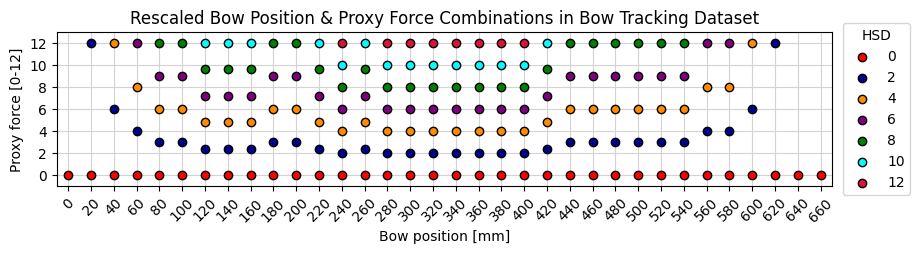

In [42]:
pos_uniques = dataset["position"].unique()

plt.figure(figsize=(10,2))

n_combos = 0

colours = ["red", "darkblue", "darkorange", "purple", "green", "cyan", "crimson"]
hsd_values = np.arange(0, 13, 2)

for pos in pos_uniques:
    pos_subset = dataset[dataset["position"] == pos]
    force_uniques = pos_subset["force"].unique()
    
    for idx, force in enumerate(force_uniques):
        plt.scatter(pos, force, c=colours[idx], ec="black", zorder=3, label=hsd_values[idx])
        n_combos += 1

print(f"Number of combinations: {n_combos}")

# Formatting
plt.xticks(np.arange(0, 670, 20), rotation=45)
plt.xlim(-10,670)
plt.ylim(-1, 13)
plt.yticks(np.arange(0, 13, 2))
plt.grid(which="both", color="lightgrey", zorder=1)
plt.xlabel("Bow position [mm]")
plt.ylabel("Proxy force [0-12]")
plt.title("Rescaled Bow Position & Proxy Force Combinations in Bow Tracking Dataset")

# Remove legend duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title="HSD", loc="right", bbox_to_anchor=[1.11, 0.5, 0, 0])

plt.show()